In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 11.7 MB/s eta 0:00:00


In [2]:
from nltk.corpus import stopwords
from datasets import load_dataset
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from gensim.models.word2vec import Word2Vec
from sklearn.decomposition import PCA
from sklearn import decomposition
import numpy as np
import pyarrow
import spacy
import nltk
from tqdm import tqdm
import torchtext
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import random
def seed_everything(seed=73):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(1234)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.0.0+cu118
torchtext Version:  0.15.1+cpu
Using GPU.


In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [5]:
dataset  = load_dataset("go_emotions", "simplified")

train = dataset['train'].to_pandas()
validation = dataset['validation'].to_pandas()
test = dataset['test'].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
initial_emotion_dict = {0: 'admiration',
1: 'amusement',
2: 'anger',
3: 'annoyance',
4: 'approval',
5: 'caring',
6: 'confusion',
7: 'curiosity',
8: 'desire',
9: 'disappointment',
10: 'disapproval',
11: 'disgust',
12: 'embarrassment',
13: 'excitement',
14: 'fear',
15: 'gratitude',
16: 'grief',
17: 'joy',
18: 'love',
19: 'nervousness',
20: 'optimism',
21: 'pride',
22: 'realization',
23: 'relief',
24: 'remorse',
25: 'sadness',
26: 'surprise',
27: 'neutral'}

n_labels = len(initial_emotion_dict)+1

In [7]:
subsets = train.labels.value_counts().index[0:14]
print(subsets) #returns most frequent 13 indexes + other_emotions for the rest.
kept_labels = [index[0] for index in subsets]
print(kept_labels)
kept_labels = np.array(kept_labels)

Index([[27], [0], [4], [15], [1], [3], [18], [10], [7], [2], [20], [6], [17],
       [25]],
      dtype='object')
[27, 0, 4, 15, 1, 3, 18, 10, 7, 2, 20, 6, 17, 25]


In [8]:
N_CLASSES = len(kept_labels)+1  #for other_emotions

not_kept_labels = np.arange(0,28)
not_kept_labels = np.delete(not_kept_labels, kept_labels)

def one_hot_encoder(df):
    one_hot_encoding = []
    for i in tqdm(range(len(df))):
        temp = [0]*n_labels
        label_indices = df.iloc[i]["labels"]
        for index in label_indices:
            if index in kept_labels:
              temp[index] = 1
            else:
              temp[n_labels-1] = 1 #other_emotions become 1
        temp = np.delete(temp,not_kept_labels)
        one_hot_encoding.append(temp)
    return pd.DataFrame(one_hot_encoding)

In [9]:
train_labels = one_hot_encoder(train)
valid_labels = one_hot_encoder(validation)
test_labels = one_hot_encoder(test)




  0%|          | 0/43410 [00:00<?, ?it/s]


  3%|▎         | 1370/43410 [00:00<00:03, 13692.41it/s]


  7%|▋         | 2903/43410 [00:00<00:02, 14654.87it/s]


 10%|█         | 4435/43410 [00:00<00:02, 14954.98it/s]


 14%|█▍        | 5970/43410 [00:00<00:02, 15108.62it/s]


 17%|█▋        | 7481/43410 [00:00<00:02, 14795.18it/s]


 21%|██        | 8962/43410 [00:00<00:02, 14404.34it/s]


 24%|██▍       | 10476/43410 [00:00<00:02, 14635.58it/s]


 28%|██▊       | 11942/43410 [00:00<00:02, 14474.41it/s]


 31%|███       | 13476/43410 [00:00<00:02, 14736.94it/s]


 34%|███▍      | 14952/43410 [00:01<00:01, 14305.09it/s]


 38%|███▊      | 16399/43410 [00:01<00:01, 14352.64it/s]


 41%|████▏     | 17967/43410 [00:01<00:01, 14746.73it/s]


 45%|████▍     | 19482/43410 [00:01<00:01, 14865.46it/s]


 49%|████▊     | 21055/43410 [00:01<00:01, 15120.93it/s]


 52%|█████▏    | 22569/43410 [00:01<00:01, 14613.93it/s]


 55%|█████▌    | 24035/43410 [00:01<00:01, 14123.66it/s]


 59%|█████▉    

In [10]:
train = pd.concat([train, train_labels], axis=1)
valid = pd.concat([validation, valid_labels], axis=1)
test = pd.concat([test, test_labels], axis=1)

In [11]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
emotion_dict = dict()
for index,value in enumerate(np.sort(kept_labels)):
    emotion_dict[index] = initial_emotion_dict[value]
emotion_dict[len(kept_labels)] = 'other_emotions'
emotion_dict

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'confusion',
 6: 'curiosity',
 7: 'disapproval',
 8: 'gratitude',
 9: 'joy',
 10: 'love',
 11: 'optimism',
 12: 'sadness',
 13: 'neutral',
 14: 'other_emotions'}

In [13]:
tokenizer = RegexpTokenizer(r"[\w']+")
en_stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [14]:
import re

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(words):
    word_list = []
    for word in words:
        if word not in en_stop:
            word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            word_list.append(word)
    return word_list

#sentences first are tokenized and return a list for each and the lists will be lemmatized and returns a list of lemmatized words by using above pre_process function. 
def tokenize(df_text):
    token_list = []
    for sentences in df_text:
        sentences = re.sub('[^A-Za-z0-9 ]+', '', sentences)
        token_list.append(lemmatize(tokenizer.tokenize(sentences.lower())))
    return token_list
        
#####OPTION 2####
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     doc = nlp(texts) 
#     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

# for i, splits in enumerate(sentence_list):
#     print(i)
#     for sentences in splits:
#         sentences = sentences.as_py()
#         token_list[i] = token_list[i] + [lemmatization(sentences)[0]]

####OPTION 3#####
# for i, splits in enumerate(sentence_list):
#     print(i)
#     for sentences in splits:
#         sentences = sentences.as_py()
#         token_list[i] = token_list[i] + [gensim.utils.simple_preprocess(sentences)]

In [15]:
train_text = tokenize(train.text)
valid_text = tokenize(valid.text)
test_text = tokenize(test.text) #tokenized words

In [16]:
LEARNING_RATE = 1e-3
N_EPOCHS = 25
BATCH_SIZE = 64
HIDDEN_DIM = 256
OUTPUT_DIM = 15
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_VOCAB_SIZE = 25_000

In [17]:
from torchtext import vocab
from collections import OrderedDict
import torchtext.transforms as T

glove_vectors = vocab.GloVe(
    name="6B",
    dim=300,
    max_vectors=MAX_VOCAB_SIZE
)

text_vocab = vocab.vocab(glove_vectors.stoi, min_freq=0, specials=['<unk>', '<pad>'], special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

unk_vector = torch.empty(1, glove_vectors.dim).normal_()
pad_vector =torch.zeros(1, glove_vectors.dim)
pretrained_weights = torch.concatenate((unk_vector, pad_vector, glove_vectors.vectors), axis=0)
pretrained_weights = torch.FloatTensor(pretrained_weights)

vocab_transform = T.VocabTransform(text_vocab)

class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[0], list):
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")

text_transform = T.Sequential(
    T.VocabTransform(text_vocab),  # Convert to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

lengths_transform = T.Sequential(
    ToLengths(),
    T.ToTensor(),
)

PAD_IDX = text_vocab["<pad>"]

.vector_cache/glove.6B.zip: 862MB [02:43, 5.26MB/s]                           
100%|█████████▉| 24999/25000 [00:02<00:00, 9449.48it/s]


In [18]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    texts, labels = zip(*batch)
    
    labels = torch.tensor(labels)
    lengths = lengths_transform(list(texts))
    texts = text_transform(list(texts))
    # print(labels)
    # print(lengths)
    # print(texts)

    return {
            "texts": torch.tensor(texts, dtype=torch.long),
            "lengths": torch.tensor(lengths, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }

def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

train_data = [[i,j] for i,j in zip(train_text,train[range(N_CLASSES)].values.tolist()) if i != []]
valid_data = [[i,j] for i,j in zip(valid_text,valid[range(N_CLASSES)].values.tolist()) if i != []]
test_data = [[i,j] for i,j in zip(test_text,test[range(N_CLASSES)].values.tolist()) if i != []]

train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [19]:
# it = iter(train_dataloader)
# first = next(it)
# second = next(it)

In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, pretrained_weights):
        super().__init__()
        
        self.num_directions = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=True, padding_idx=pad_idx)        
        self.rnn = nn.LSTM(pretrained_weights.shape[1],
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)   
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, texts, lengths):
        embedded = self.dropout(self.embedding(texts))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        if self.num_directions == 2:

            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

In [21]:


#######pretrained_weights = np.concatenate((w2v_weights, special_weights), axis=0)#####
model = RNN(HIDDEN_DIM, 
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT,
    PAD_IDX,
    pretrained_weights
)
model.to(DEVICE)

RNN(
  (embedding): Embedding(25002, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=15, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [22]:
def loss_fn(outputs, targets):
    criterion = nn.BCEWithLogitsLoss()
    criterion = criterion.to(DEVICE)
    loss = criterion(outputs.view(-1, N_CLASSES), 
                  targets.float().view(-1, N_CLASSES))
    if targets is None:
        return None
    return loss

optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

In [23]:
def train_fn(model, train_dataloader, optimizer):
    
    train_loss = 0.0
    model.train()

    for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        texts = d["texts"]
        lengths = d["lengths"]
        targets = d["labels"]

        texts = texts.to(DEVICE, dtype=torch.long)
        lengths = lengths.to(DEVICE, dtype=torch.long)
        targets = targets.to(DEVICE, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(texts=texts, lengths=lengths)
        
        loss = loss_fn(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        model.zero_grad()
        
    return train_loss/len(train_dataloader)

In [24]:
def eval_fn(data_loader, model):
    eval_loss = 0.0
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            texts = d["texts"]
            lengths = d["lengths"]
            targets = d["labels"]

            texts = texts.to(DEVICE, dtype=torch.long)
            lengths = lengths.to(DEVICE, dtype=torch.long)
            targets = targets.to(DEVICE, dtype=torch.float)

            outputs = model(texts=texts, lengths=lengths)
            loss = loss_fn(outputs, targets)
            eval_loss += loss.item()
            fin_targets.extend(targets)
            fin_outputs.extend(torch.sigmoid(outputs))
            
    return eval_loss/len(data_loader), fin_outputs, fin_targets

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
import time

best_train_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()
    
    train_loss = train_fn(model, train_dataloader, optimizer)
    print(f'\tTrain Loss: {train_loss:.3f}')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Using GPU for training.
Epoch: 01


100%|██████████| 677/677 [00:07<00:00, 91.30it/s] 


	Train Loss: 0.222
Epoch: 02


100%|██████████| 677/677 [00:05<00:00, 127.41it/s]


	Train Loss: 0.190
Epoch: 03


100%|██████████| 677/677 [00:05<00:00, 115.26it/s]


	Train Loss: 0.182
Epoch: 04


100%|██████████| 677/677 [00:05<00:00, 132.12it/s]


	Train Loss: 0.177
Epoch: 05


100%|██████████| 677/677 [00:05<00:00, 116.60it/s]


	Train Loss: 0.172
Epoch: 06


100%|██████████| 677/677 [00:05<00:00, 130.30it/s]


	Train Loss: 0.167
Epoch: 07


100%|██████████| 677/677 [00:05<00:00, 133.14it/s]


	Train Loss: 0.161
Epoch: 08


100%|██████████| 677/677 [00:05<00:00, 113.74it/s]


	Train Loss: 0.154
Epoch: 09


100%|██████████| 677/677 [00:05<00:00, 131.57it/s]


	Train Loss: 0.146
Epoch: 10


100%|██████████| 677/677 [00:05<00:00, 115.45it/s]


	Train Loss: 0.138
Epoch: 11


100%|██████████| 677/677 [00:05<00:00, 130.55it/s]


	Train Loss: 0.130
Epoch: 12


100%|██████████| 677/677 [00:05<00:00, 115.15it/s]


	Train Loss: 0.122
Epoch: 13


100%|██████████| 677/677 [00:05<00:00, 132.44it/s]


	Train Loss: 0.115
Epoch: 14


100%|██████████| 677/677 [00:05<00:00, 121.54it/s]


	Train Loss: 0.109
Epoch: 15


100%|██████████| 677/677 [00:05<00:00, 121.01it/s]


	Train Loss: 0.102
Epoch: 16


100%|██████████| 677/677 [00:05<00:00, 128.48it/s]


	Train Loss: 0.097
Epoch: 17


100%|██████████| 677/677 [00:05<00:00, 114.77it/s]


	Train Loss: 0.092
Epoch: 18


100%|██████████| 677/677 [00:05<00:00, 129.00it/s]


	Train Loss: 0.088
Epoch: 19


100%|██████████| 677/677 [00:05<00:00, 114.79it/s]


	Train Loss: 0.084
Epoch: 20


100%|██████████| 677/677 [00:05<00:00, 132.68it/s]


	Train Loss: 0.080
Epoch: 21


100%|██████████| 677/677 [00:05<00:00, 115.92it/s]


	Train Loss: 0.077
Epoch: 22


100%|██████████| 677/677 [00:05<00:00, 129.05it/s]


	Train Loss: 0.073
Epoch: 23


100%|██████████| 677/677 [00:05<00:00, 122.60it/s]


	Train Loss: 0.071
Epoch: 24


100%|██████████| 677/677 [00:05<00:00, 119.42it/s]


	Train Loss: 0.067
Epoch: 25


100%|██████████| 677/677 [00:05<00:00, 127.96it/s]

	Train Loss: 0.067


In [27]:
valid_loss, valid_outputs, valid_targets=eval_fn(valid_dataloader,model)

100%|██████████| 85/85 [00:00<00:00, 212.85it/s]


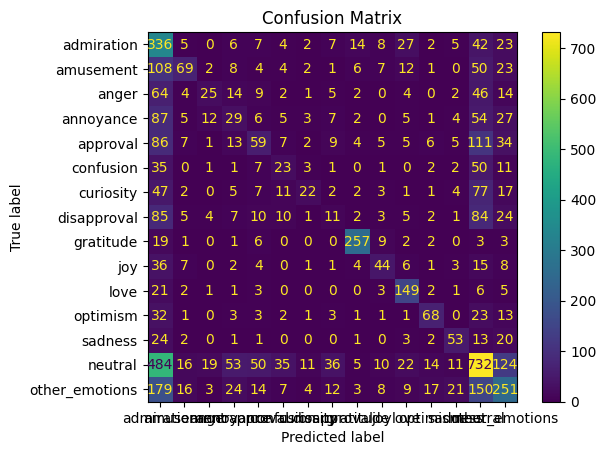

                precision    recall  f1-score   support

    admiration       0.65      0.53      0.58       488
     amusement       0.49      0.23      0.31       303
         anger       0.37      0.13      0.19       195
     annoyance       0.18      0.11      0.14       303
      approval       0.33      0.17      0.23       396
     confusion       0.23      0.17      0.20       150
     curiosity       0.40      0.09      0.15       243
   disapproval       0.14      0.05      0.08       291
     gratitude       0.93      0.87      0.90       358
           joy       0.53      0.37      0.43       172
          love       0.70      0.78      0.74       252
      optimism       0.64      0.42      0.50       209
       sadness       0.55      0.45      0.49       143
       neutral       0.53      0.46      0.49      1758
other_emotions       0.51      0.35      0.42      1036

     micro avg       0.54      0.38      0.45      6297
     macro avg       0.48      0.34      0.39 

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, auc, roc_curve 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(labels,preds):
    preds = torch.stack(preds)
    preds = preds.cpu().detach().numpy()
    labels = torch.stack(labels)
    labels = labels.cpu().detach().numpy()
    
    assert len(preds) == len(labels)
    results = dict()

    fpr_micro, tpr_micro, _ = roc_curve(labels.ravel(), preds.ravel())
    results["auc_micro"] = auc(fpr_micro, tpr_micro)

    cm = confusion_matrix(labels.argmax(axis=1),preds.argmax(axis=1)) #confusion matrix of adjusted threshold
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_dict.values())
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    labels = labels.tolist()
    print(classification_report(labels,preds,target_names=emotion_dict.values()))
    
    results["accuracy"] = accuracy_score(labels, preds)

    results["macro_precision"], results["macro_recall"], results[
        "macro_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="macro")

    results["micro_precision"], results["micro_recall"], results[
        "micro_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="micro")

    results["weighted_precision"], results["weighted_recall"], results[
        "weighted_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="weighted")

    return results

threshold = 0.6
valid_preds = [torch.ceil(output-threshold) for output in valid_outputs]

result = compute_metrics(valid_targets,valid_preds)

print("validation loss:", valid_loss)
print("validation metric results:", result)

In [29]:
test_loss, test_outputs, test_targets=eval_fn(test_dataloader,model)

100%|██████████| 85/85 [00:00<00:00, 143.67it/s]


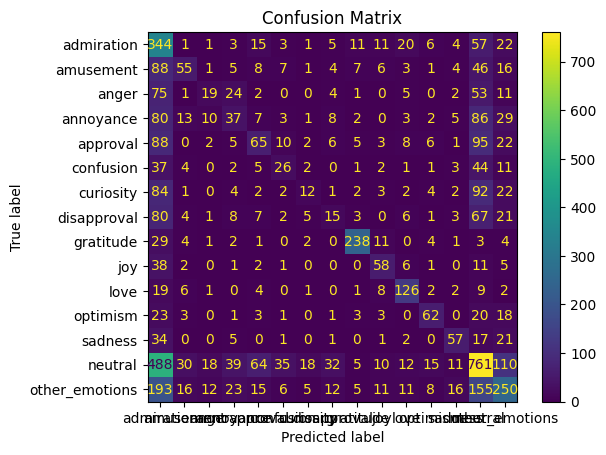

                precision    recall  f1-score   support

    admiration       0.62      0.53      0.57       504
     amusement       0.38      0.21      0.27       264
         anger       0.29      0.10      0.14       198
     annoyance       0.27      0.15      0.19       320
      approval       0.35      0.21      0.26       351
     confusion       0.29      0.19      0.23       153
     curiosity       0.23      0.05      0.08       283
   disapproval       0.19      0.07      0.11       267
     gratitude       0.92      0.86      0.89       352
           joy       0.55      0.48      0.51       161
          love       0.74      0.77      0.75       238
      optimism       0.60      0.40      0.48       186
       sadness       0.55      0.42      0.47       156
       neutral       0.54      0.47      0.51      1783
other_emotions       0.51      0.33      0.40      1054

     micro avg       0.54      0.39      0.45      6270
     macro avg       0.47      0.35      0.39 

In [30]:
test_preds = [torch.ceil(output-threshold) for output in test_outputs]

result = compute_metrics(test_targets,test_preds)

print("test loss:", test_loss)
print("test metric results:", result)

In [31]:
def predict_sentiment(model, sentence):

    def sentence_tokenize(sentence):
        token_list = []
        sentences = re.sub('[^A-Za-z0-9 ]+', '', sentence)
        token_list.append(lemmatize(tokenizer.tokenize(sentences.lower())))
        return token_list[0]

    tokenized = sentence_tokenize(sentence)
    print(tokenized)
    processed_sentence = text_transform([tokenized]).to(DEVICE)
    print(processed_sentence)
    sentence_length = lengths_transform([tokenized]).cpu()
    print(sentence_length)
    
    model.eval()
    logits = torch.sigmoid(model(processed_sentence, sentence_length))
    print(logits)
    result = torch.sigmoid(logits)
    print(result)

    threshold = 0.6
    valid_result = torch.ceil(result-threshold)

    return valid_result

In [32]:
predict_sentiment(model,"Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit")

['troll', 'bro', 'know', 'theyre', 'say', 'stupid', 'shit', 'motherfucker', 'nothing', 'stink', 'libertarian', 'sub', 'talk', 'shit']
tensor([[    0,     0,   348,     0,   205,  8981,     0,     0,   938,     0,
         17545,  5522,  1079,     0]], device='cuda:0')
tensor([14])
tensor([[4.2338e-05, 1.1864e-01, 6.7534e-01, 2.1681e-02, 6.2582e-04, 2.1998e-03,
         7.8281e-05, 1.7899e-01, 6.6319e-04, 8.2009e-05, 1.5457e-06, 3.0886e-03,
         4.1403e-06, 2.4484e-02, 2.1062e-03]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
tensor([[0.5000, 0.5296, 0.6627, 0.5054, 0.5002, 0.5005, 0.5000, 0.5446, 0.5002,
         0.5000, 0.5000, 0.5008, 0.5000, 0.5061, 0.5005]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


tensor([[-0., -0., 1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]],
       device='cuda:0', grad_fn=<CeilBackward0>)